# Flight Delay Predictor

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Prepare Dataset and Feature Engineering

### Categorical Features
This section transforms categorical variables into numerical representations that the model can use using one-hot encoding:

- **Carrier Code**: Airlines have different operational patterns and reliability. One-hot encoding converts each carrier into a binary feature column.
- **Destination Airport**: Airports experience different congestion levels and weather impacts. We one-hot encode the top 20 airports by frequency and group less common airports into an "OTHER" category.
- **Flight Number**: Regular flights often maintain consistent delay patterns. We convert flight numbers into average historical delay values for that specific flight.

In [3]:
# Load the datasets
flight_df = pd.read_csv('2016-2021.csv')
weather_df = pd.read_csv('2016-2021_weather.csv')

# Make sure datetime columns are in datetime format
flight_df['Scheduled Departure Datetime'] = pd.to_datetime(flight_df['Scheduled Departure Datetime'])
flight_df['Rounded Datetime'] = pd.to_datetime(flight_df['Rounded Datetime'])
weather_df['Rounded Datetime'] = pd.to_datetime(weather_df['Rounded Datetime'])

# Handling categorical variables
# For Carrier Code - One-hot encoding
encoder_carrier = OneHotEncoder(sparse_output=False, drop='first')
carrier_encoded = encoder_carrier.fit_transform(flight_df[['Carrier Code']])
carrier_columns = [f'carrier_{cat}' for cat in encoder_carrier.categories_[0][1:]]
carrier_df = pd.DataFrame(carrier_encoded, columns=carrier_columns)

# For Destination Airport - One-hot encoding for top airports, group others
# Identify top 20 airports by frequency
top_airports = flight_df['Destination Airport'].value_counts().nlargest(20).index
flight_df['Airport_Category'] = flight_df['Destination Airport'].apply(
    lambda x: x if x in top_airports else 'OTHER')

encoder_airport = OneHotEncoder(sparse_output=False, drop='first')
airport_encoded = encoder_airport.fit_transform(flight_df[['Airport_Category']])
airport_columns = [f'airport_{cat}' for cat in encoder_airport.categories_[0][1:]]
airport_df = pd.DataFrame(airport_encoded, columns=airport_columns)

# For Flight Number - Create frequency-based features
flight_delay_avg = flight_df.groupby('Flight Number')['Departure Delay (Minutes)'].mean().reset_index()
flight_delay_avg.columns = ['Flight Number', 'Avg_Delay_Flight']
flight_df = pd.merge(flight_df, flight_delay_avg, on='Flight Number', how='left')

# Fill NaN values for flights with no history
# flight_df['Avg_Delay_Flight'].fillna(flight_df['Avg_Delay_Flight'].mean(), inplace=True)

### Time-based Features

Additionally, we also try to capture time patterns that represent real life scenarios:

- **Day of Week**: Encoded as one-hot vectors to capture weekly patterns (Monday flights vs. Friday flights).
- **Month**: One-hot encoded to represent seasonal variations.
- **Hour Bins**: Time of day grouped into meaningful periods (morning, afternoon, evening, night) to capture time-of-day patterns.
- **Holiday Flag**: Binary indicator (0/1) for whether the flight date falls on a U.S. federal holiday.

In [4]:
# Extract time-based features
flight_df['Day_of_Week'] = flight_df['Scheduled Departure Datetime'].dt.dayofweek
flight_df['Month'] = flight_df['Scheduled Departure Datetime'].dt.month
flight_df['Hour'] = flight_df['Scheduled Departure Datetime'].dt.hour

# One-hot encode day of week
encoder_dow = OneHotEncoder(sparse_output=False, drop='first')
dow_encoded = encoder_dow.fit_transform(flight_df[['Day_of_Week']])
dow_columns = [f'dow_{cat}' for cat in range(1, 7)]  # Since we drop the first category
dow_df = pd.DataFrame(dow_encoded, columns=dow_columns)

# One-hot encode month
encoder_month = OneHotEncoder(sparse_output=False, drop='first')
month_encoded = encoder_month.fit_transform(flight_df[['Month']])
month_columns = [f'month_{cat}' for cat in range(2, 13)]  # Since we drop the first category
month_df = pd.DataFrame(month_encoded, columns=month_columns)

# One-hot encode hour (binned)
# Group hours into morning (5-11), afternoon (12-17), evening (18-23), night (0-4)
flight_df['Hour_Bin'] = pd.cut(
    flight_df['Hour'],
    bins=[-1, 4, 11, 17, 23],
    labels=['night', 'morning', 'afternoon', 'evening']
)
encoder_hour = OneHotEncoder(sparse_output=False, drop='first')
hour_encoded = encoder_hour.fit_transform(flight_df[['Hour_Bin']])
hour_columns = [f'hour_{cat}' for cat in encoder_hour.categories_[0][1:]]
hour_df = pd.DataFrame(hour_encoded, columns=hour_columns)

# US holidays detection
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=flight_df['Scheduled Departure Datetime'].min(),
                       end=flight_df['Scheduled Departure Datetime'].max())
flight_df['Is_Holiday'] = flight_df['Scheduled Departure Datetime'].dt.date.astype('datetime64[ns]').isin(holidays).astype(int)

### Delay Patterns

Historical delay patterns to provide baseline predictions:

- **Average Delay by Airport**: Some airports  consistently experience more delays.
- **Average Delay by Carrier**: Airlines have different on-time performance records.
- **Average Delay by Hour**: Certain hours of the day are more prone to delays.
- **Average Delay by Day of Week**: Weekly patterns influence delays.
- **Average Delay by Month**: Seasonal variations affect flight operations.



In [5]:
# Airport delay patterns
airport_delay_avg = flight_df.groupby('Destination Airport')['Departure Delay (Minutes)'].mean().reset_index()
airport_delay_avg.columns = ['Destination Airport', 'Avg_Delay_Airport']
flight_df = pd.merge(flight_df, airport_delay_avg, on='Destination Airport', how='left')

# Carrier delay patterns
carrier_delay_avg = flight_df.groupby('Carrier Code')['Departure Delay (Minutes)'].mean().reset_index()
carrier_delay_avg.columns = ['Carrier Code', 'Avg_Delay_Carrier']
flight_df = pd.merge(flight_df, carrier_delay_avg, on='Carrier Code', how='left')

# Time-based patterns (e.g., hour of day)
hour_delay_avg = flight_df.groupby('Hour')['Departure Delay (Minutes)'].mean().reset_index()
hour_delay_avg.columns = ['Hour', 'Avg_Delay_Hour']
flight_df = pd.merge(flight_df, hour_delay_avg, on='Hour', how='left')

# Day of week patterns
dow_delay_avg = flight_df.groupby('Day_of_Week')['Departure Delay (Minutes)'].mean().reset_index()
dow_delay_avg.columns = ['Day_of_Week', 'Avg_Delay_DOW']
flight_df = pd.merge(flight_df, dow_delay_avg, on='Day_of_Week', how='left')

# Month patterns
month_delay_avg = flight_df.groupby('Month')['Departure Delay (Minutes)'].mean().reset_index()
month_delay_avg.columns = ['Month', 'Avg_Delay_Month']
flight_df = pd.merge(flight_df, month_delay_avg, on='Month', how='left')

### Weather Features

Weather is a key factor affecting flight delays:

- For each flight, we extract weather data from a window of time (e.g., 5 hours) before the scheduled departure.
- We focus on air temperature, dew temperature, sea level pressure, wind direction, wind speed, sky condition, and precipitation.
- If fewer than n hours of data are available, we pad the sequence to maintain consistent dimensions.
- We calculate trend indicators to capture whether weather conditions are improving or worsening.

In [6]:
# Function to get weather sequence for a flight, takes a while to finish
def get_weather_sequence(flight_row, weather_df, hours_before=5):
    flight_time = flight_row['Scheduled Departure Datetime']

    # Get weather data for the specified window before flight
    weather_window = weather_df[
        (weather_df['Rounded Datetime'] <= flight_time) &
        (weather_df['Rounded Datetime'] >= (flight_time - pd.Timedelta(hours=hours_before)))
    ].sort_values('Rounded Datetime')

    # Extract only the important weather features
    weather_features = [
        'Air Temperature', 'Dew Temperature', 'Sea Level Pressure',
        'Wind Direction', 'Wind Speed Rate', 'Sky Condition', 'Precip 1 Hour'
    ]

    # Create a fixed-length sequence (padded if necessary)
    sequence = weather_window[weather_features].values

    # If we have less than hours_before entries, pad with zeros (or last known values)
    if len(sequence) < hours_before:
        # For simplicity, pad with zeros. In practice, you might use the last known values.
        padding = np.zeros((hours_before - len(sequence), len(weather_features)))
        sequence = np.vstack([padding, sequence])

    # If we have more than hours_before entries, take the most recent ones
    elif len(sequence) > hours_before:
        sequence = sequence[-hours_before:]

    # Calculate weather trends
    if len(weather_window) >= 2:
        # For each feature, calculate the slope of the line over time
        trends = []
        for feature in weather_features:
            if len(weather_window[feature]) >= 2:
                # Simple slope calculation: (end - start) / time_diff
                trend = (weather_window[feature].iloc[-1] - weather_window[feature].iloc[0]) / len(weather_window)
                trends.append(trend)
            else:
                trends.append(0)
    else:
        trends = [0] * len(weather_features)

    return sequence, trends

# Apply the function to each flight
# This will take time, so consider processing in batches or parallel
weather_sequences = []
weather_trends = []

# Process flights in batches to avoid memory issues
batch_size = 1000
for i in range(0, len(flight_df), batch_size):
    batch = flight_df.iloc[i:i+batch_size]
    batch_sequences = []
    batch_trends = []

    for _, flight in batch.iterrows():
        seq, trend = get_weather_sequence(flight, weather_df)
        batch_sequences.append(seq)
        batch_trends.append(trend)

    weather_sequences.extend(batch_sequences)
    weather_trends.extend(batch_trends)

# Convert to numpy arrays
weather_sequences = np.array(weather_sequences)
weather_trends = np.array(weather_trends)

# Name the trend features
trend_columns = [f'{feature}_trend' for feature in [
    'Air_Temp', 'Dew_Temp', 'Sea_Level_Pressure',
    'Wind_Direction', 'Wind_Speed', 'Sky_Condition', 'Precipitation'
]]
trend_df = pd.DataFrame(weather_trends, columns=trend_columns)

### Feature Scaling and Normalization

Scaling ensures fair contribution from all features:

- Standardization: We apply standard scaling (zero mean, unit variance) to all numerical features.
- Target Variable Normalization: The delay minutes are also scaled to improve model training stability.

In [7]:
# Combine all engineered features
static_features = pd.concat([
    flight_df[['Departure Delay (Minutes)']],  # Target variable
    carrier_df, airport_df, dow_df, month_df, hour_df,
    flight_df[['Avg_Delay_Flight', 'Avg_Delay_Airport', 'Avg_Delay_Carrier',
               'Avg_Delay_Hour', 'Avg_Delay_DOW', 'Avg_Delay_Month', 'Is_Holiday']]
], axis=1)

# Scale numerical features
numerical_columns = ['Avg_Delay_Flight', 'Avg_Delay_Airport', 'Avg_Delay_Carrier',
                     'Avg_Delay_Hour', 'Avg_Delay_DOW', 'Avg_Delay_Month']
scaler = StandardScaler()
static_features[numerical_columns] = scaler.fit_transform(static_features[numerical_columns])

# Scale the trend features
trend_df = pd.DataFrame(scaler.fit_transform(trend_df), columns=trend_df.columns)

# Final combined dataset
final_features = pd.concat([static_features, trend_df], axis=1)

# Create PyTorch Dataset
class FlightDelayDataset(Dataset):
    """
    Handles both static features (one value per flight) and sequential features (weather time series).
    Returns dictionary-like samples with 'static', 'weather_seq', and 'target' keys.
    Converts all data to PyTorch tensors with appropriate data types.
    """
    def __init__(self, static_features, weather_sequences, targets):
        self.static_features = torch.tensor(static_features.values, dtype=torch.float32)
        self.weather_sequences = torch.tensor(weather_sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'static': self.static_features[idx],
            'weather_seq': self.weather_sequences[idx],
            'target': self.targets[idx]
        }

# Split the data
X_static = final_features.drop('Departure Delay (Minutes)', axis=1)
y = final_features[['Departure Delay (Minutes)']]

X_train_static, X_test_static, X_train_seq, X_test_seq, y_train, y_test = train_test_split(
    X_static, weather_sequences, y, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = FlightDelayDataset(X_train_static, X_train_seq, y_train)
test_dataset = FlightDelayDataset(X_test_static, X_test_seq, y_test)


In [8]:
# Create a scaler specifically for the target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y)

# During training, work with scaled targets
# For predictions, remember to inverse transform:
# y_pred = target_scaler.inverse_transform(model_output)

# Update the dataset creation
y_train_scaled = target_scaler.transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

train_dataset = FlightDelayDataset(X_train_static, X_train_seq, pd.DataFrame(y_train_scaled))
test_dataset = FlightDelayDataset(X_test_static, X_test_seq, pd.DataFrame(y_test_scaled))

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 2. Model Architecture

- Dual Input Paths: Processes static features and weather sequences separately before combining them.
- LSTM for Weather: Uses Long Short-Term Memory networks to process the weather time series data.
- Attention Mechanism: Allows the model to focus on the most relevant weather time steps.
- Dropout Regularization: Prevents overfitting by randomly dropping neurons during training.
- Batch Normalization: Stabilizes and accelerates training.
- Skip Connections: Improve gradient flow in deeper networks.
- Gradient Clipping: Prevents exploding gradients during training.

In [18]:
class ImprovedFlightDelayModel(nn.Module):
    def __init__(self, static_dim, seq_feature_dim, hidden_dim=128, num_layers=2, dropout=0.3):
        super(ImprovedFlightDelayModel, self).__init__()

        # Improved LSTM for weather sequence
        self.lstm = nn.LSTM(
            input_size=seq_feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention mechanism for weather sequence
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )

        # Deeper network for static features
        self.fc_static = nn.Sequential(
            nn.Linear(static_dim, hidden_dim*2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim*2),  # Add batch normalization
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )

        # Final prediction layers with skip connection
        self.fc_combined = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, static, weather_seq):
        batch_size = static.size(0)

        # Process static features
        static_out = self.fc_static(static)

        # Process weather sequence with LSTM
        lstm_out, _ = self.lstm(weather_seq)  # Shape: [batch, seq_len, hidden]

        # Apply attention to focus on important time steps
        attention_weights = self.attention(lstm_out)  # Shape: [batch, seq_len, 1]
        context = torch.bmm(attention_weights.transpose(1, 2), lstm_out)  # Shape: [batch, 1, hidden]
        context = context.squeeze(1)  # Shape: [batch, hidden]

        # Combine features
        combined = torch.cat([static_out, context], dim=1)

        # Final prediction
        out = self.fc_combined(combined)
        return out

In [19]:
def plot_training_progress(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Log scale often helps visualize learning curves

    # Add second subplot for a zoomed-in view if needed
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses[5:], label='Training Loss')  # Skip first few epochs
    plt.plot(val_losses[5:], label='Validation Loss')
    plt.xlabel('Epochs (after 5)')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss (Later Epochs)')
    plt.legend()
    plt.grid(True)

    plt.show()

### Training Process

Loss Function and Optimizer

We use:

- Mean Squared Error (MSE): Measures the squared difference between predicted and actual delays.
- Adam Optimizer: Adaptive learning rate optimization algorithm.
- Weight Decay: L2 regularization to prevent overfitting.

Learning Rate Scheduling

To improve training dynamics:

- ReduceLROnPlateau: Reduces learning rate when validation loss stops improving.
- Factor: Learning rate is multiplied by this factor (e.g., 0.5) when triggered.
- Patience: Number of epochs with no improvement before reducing learning rate.

Training Loop

The training process:

- Iterates through epochs, processing batches of data.
- Computes loss on training data and performs backpropagation.
- Validates on test data after each epoch.
- Tracks and records training and validation loss.
- Updates learning rate based on validation performance.

Early Stopping

To avoid overfitting:

- We track the best validation loss achieved.
- If validation loss doesn't improve for a set number of epochs (patience), we stop training.
- The best model state is saved for later use.

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.3136, Val Loss: 0.3025
Epoch 2, Train Loss: 0.3072, Val Loss: 0.3018
Epoch 3, Train Loss: 0.3064, Val Loss: 0.3031
Epoch 4, Train Loss: 0.3062, Val Loss: 0.3004
Epoch 5, Train Loss: 0.3058, Val Loss: 0.3011
Epoch 6, Train Loss: 0.3050, Val Loss: 0.2999
Epoch 7, Train Loss: 0.3044, Val Loss: 0.3001
Epoch 8, Train Loss: 0.3051, Val Loss: 0.2994
Epoch 9, Train Loss: 0.3043, Val Loss: 0.2994
Epoch 10, Train Loss: 0.3044, Val Loss: 0.3008
Epoch 11, Train Loss: 0.3039, Val Loss: 0.2995
Epoch 12, Train Loss: 0.3032, Val Loss: 0.3000
Epoch 13, Train Loss: 0.3027, Val Loss: 0.2996
Epoch 14, Train Loss: 0.3019, Val Loss: 0.2990
Epoch 15, Train Loss: 0.3012, Val Loss: 0.2981
Epoch 16, Train Loss: 0.3005, Val Loss: 0.2985
Epoch 17, Train Loss: 0.3002, Val Loss: 0.2979
Epoch 18, Train Loss: 0.2996, Val Loss: 0.2982
Epoch 19, Train Loss: 0.2995, Val Loss: 0.2981
Epoch 20, Train Loss: 0.2993, Val Loss: 0.2986
Epoch 21, Train Loss: 0.2985, Val Loss: 0.2993
Epoch 22, Train Loss: 

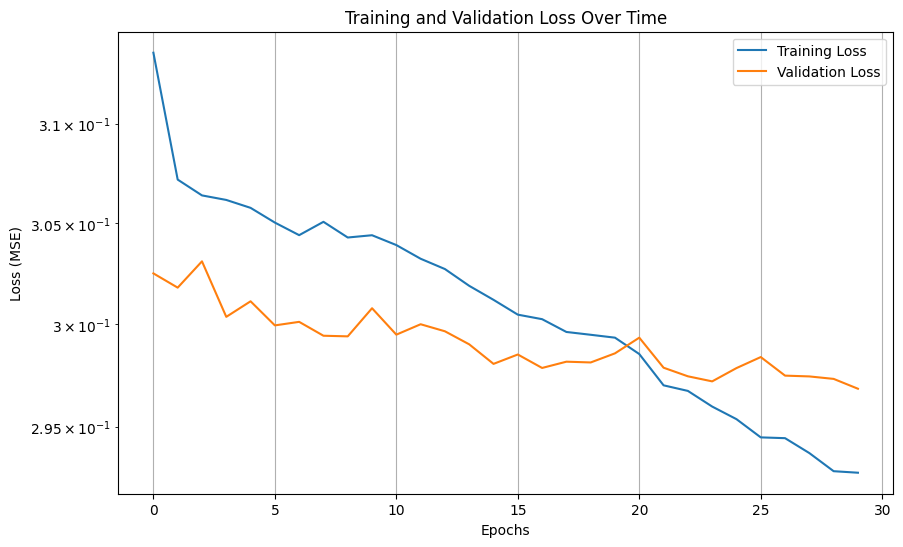

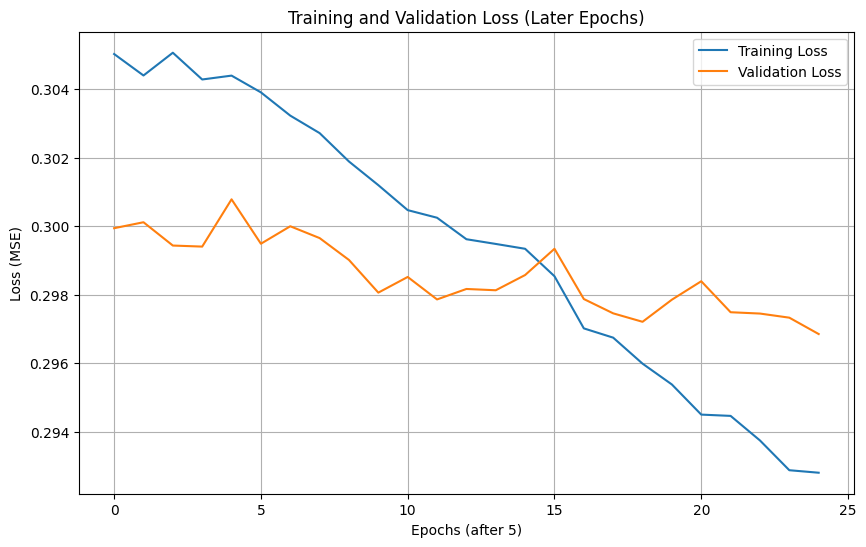

In [20]:
# Use a learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize model with improved architecture
static_dim = X_train_static.shape[1]  # Use filtered features
seq_feature_dim = weather_sequences.shape[2]

model = ImprovedFlightDelayModel(static_dim, seq_feature_dim)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training loop with early stopping
num_epochs = 30
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 7
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in train_loader:
        static = batch['static']
        weather_seq = batch['weather_seq']
        targets = batch['target']

        # Forward pass
        outputs = model(static, weather_seq)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        # Add gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss/len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            static = batch['static']
            weather_seq = batch['weather_seq']
            targets = batch['target']

            outputs = model(static, weather_seq)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss/len(test_loader)
    val_losses.append(avg_val_loss)

    # Update learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_flight_delay_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plot training progress
plot_training_progress(train_losses, val_losses)

## 3. Evaluation

MAE: 15.95 minutes
RMSE: 51.40 minutes
R² Score: 0.0445


<ipython-input-31-7ffe6498265d>:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


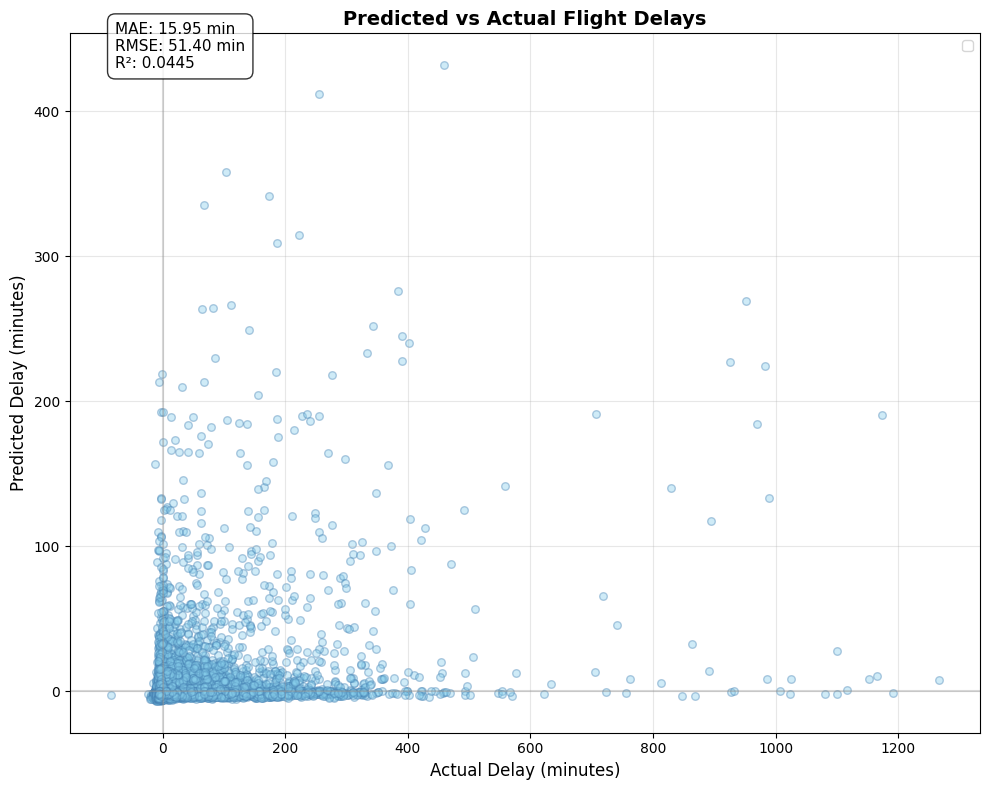

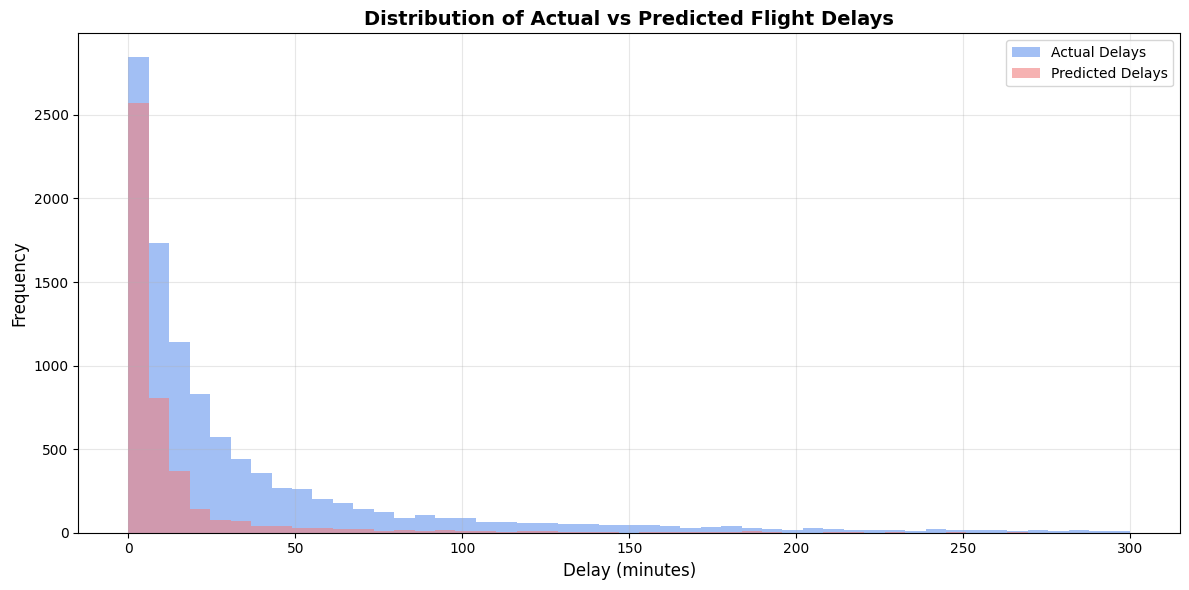

In [31]:
# Load the best model
model.load_state_dict(torch.load('best_flight_delay_model.pth'))
model.eval()

# Get predictions
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        static = batch['static']
        weather_seq = batch['weather_seq']
        targets = batch['target']

        outputs = model(static, weather_seq)

        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Convert back to original scale
y_pred_original = target_scaler.inverse_transform(y_pred)
y_true_original = target_scaler.inverse_transform(y_true)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
r2 = r2_score(y_true_original, y_pred_original)

print(f"MAE: {mae:.2f} minutes")
print(f"RMSE: {rmse:.2f} minutes")
print(f"R² Score: {r2:.4f}")

# 1. Enhanced scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_true_original, y_pred_original, alpha=0.4, color='skyblue',
            edgecolor='steelblue', s=30)

# Add some context lines
# plt.axline([0, 0], [100, 100], color='green', linestyle='--', alpha=0.7,
#            label='Perfect Prediction')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)

# Improve labels and styling
plt.xlabel('Actual Delay (minutes)', fontsize=12)
plt.ylabel('Predicted Delay (minutes)', fontsize=12)
plt.title('Predicted vs Actual Flight Delays', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Add annotation for model performance
plt.annotate(f"MAE: {mae:.2f} min\nRMSE: {rmse:.2f} min\nR²: {r2:.4f}",
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
             fontsize=11)
plt.tight_layout()
plt.show()

# 2. Dual histogram showing distribution of actual vs predicted
plt.figure(figsize=(12, 6))
max_value = max(np.max(y_true_original), np.max(y_pred_original))
bins = np.linspace(0, min(max_value, 300), 50)  # Focus on delays up to 300 minutes

plt.hist(y_true_original, bins=bins, alpha=0.6, color='cornflowerblue',
         label='Actual Delays')
plt.hist(y_pred_original, bins=bins, alpha=0.6, color='lightcoral',
         label='Predicted Delays')

plt.xlabel('Delay (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Actual vs Predicted Flight Delays', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

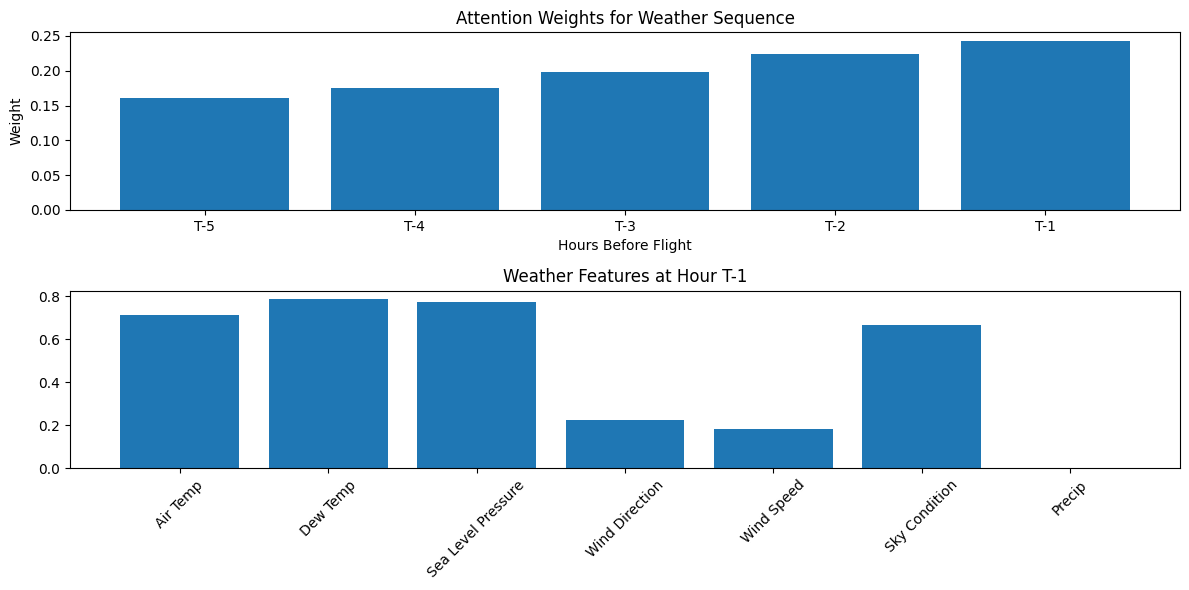

In [29]:
# Create a function to visualize attention weights on weather sequences
def visualize_attention(model, sample, weather_features):
    model.eval()
    with torch.no_grad():
        static = sample['static'].unsqueeze(0)  # Add batch dimension
        weather_seq = sample['weather_seq'].unsqueeze(0)

        # Forward pass through LSTM
        lstm_out, _ = model.lstm(weather_seq)

        # Get attention weights
        attention_weights = model.attention(lstm_out)

        # Extract weights
        weights = attention_weights.squeeze().cpu().numpy()

        # Create visualization
        plt.figure(figsize=(12, 6))

        # Plot attention weights
        plt.subplot(2, 1, 1)
        plt.bar(range(len(weights)), weights)
        plt.title('Attention Weights for Weather Sequence')
        plt.xlabel('Hours Before Flight')
        plt.ylabel('Weight')
        plt.xticks(range(len(weights)), [f'T-{i+1}' for i in range(len(weights)-1, -1, -1)])

        # Plot weather features with highest attention
        plt.subplot(2, 1, 2)
        weather_data = weather_seq.squeeze().cpu().numpy()

        # Get hour with highest attention
        max_attention_hour = np.argmax(weights)

        # Plot weather values for that hour
        plt.bar(range(len(weather_features)), weather_data[max_attention_hour])
        plt.title(f'Weather Features at Hour T-{len(weights)-max_attention_hour}')
        plt.xticks(range(len(weather_features)), weather_features, rotation=45)

        plt.tight_layout()
        plt.show()

# Example usage:
# Get a sample from test dataset
sample = test_dataset[0]
weather_features = ['Air Temp', 'Dew Temp', 'Sea Level Pressure',
                   'Wind Direction', 'Wind Speed', 'Sky Condition', 'Precip']
visualize_attention(model, sample, weather_features)